## Geodesic Exploration

In [1]:
import torch
from stochman.geodesic import geodesic_minimizing_energy
from stochman.curves import CubicSpline

from models.vae import VariationalAutoencoder

from utils.geodesic import find_geodesic
from utils.visualize import plot_overlapped

device = torch.device("cpu")

hidden_dim = 2
model = VariationalAutoencoder([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28], hidden_dim=hidden_dim).to(device)
model.load_state_dict(torch.load("./pretrained_models/manifold_vae.pth", map_location=device, weights_only=True))


<All keys matched successfully>

Using device: cpu


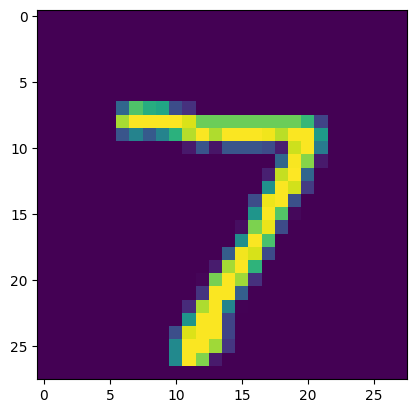

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        ]
    )

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cpu")

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=0)

print(f"Using device: {device}")


x_train, y_train = next(iter(train_loader))
x_train = x_train[:1]
y_train = y_train[:1]

x_test, y_test = next(iter(test_loader))

from collections import defaultdict

vals = defaultdict(list)

model.eval()
with torch.no_grad():
    for x, y in train_loader:
        _, z, _, _ = model(x)
        for i in range(len(y)):
            y_val = y[i].item()
            vals[y_val].append(z[i])

plt.imshow(x_train.reshape((28, 28, 1)))
plt.imshow(x_test.reshape((28, 28, 1)))


In [8]:
model.eval()
with torch.no_grad():
    _, z1, _, _ = model(x_train)
    _, z2, _, _ = model(x_test)
curve = find_geodesic(model, z1, z2)

tensor([6.7658], grad_fn=<SumBackward1>)

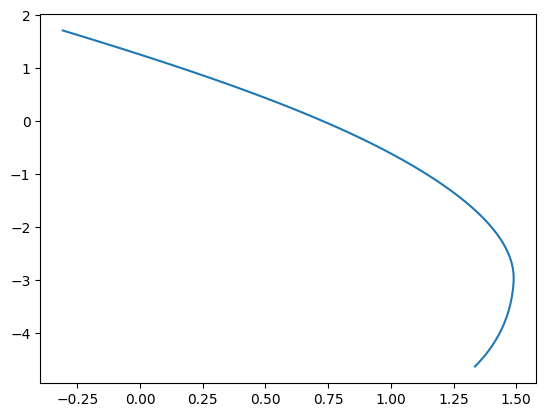

In [9]:
curve.plot()
curve.euclidean_length()

### Two points from the same class (number 5)

Geodesic length: 1.9745845794677734
Euclidean length: 2.077927589416504


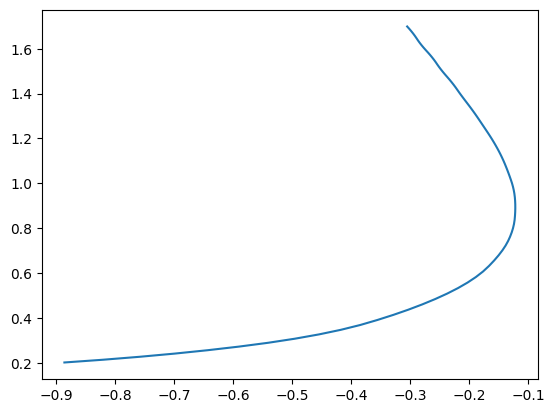

In [3]:
z1 = vals[5][0]
z2 = vals[5][1]
curve = find_geodesic(model, z1, z2)
curve.plot()
geodesic_distance = curve.euclidean_length().item()
euclidean_distance = torch.norm(z1 - z2, p=1)
print(f"Geodesic length: {geodesic_distance}")
print(f"Euclidean length: {euclidean_distance}")

### Interpolation between the two latent points following the geodesic

Curve has geodesic length: 1.9745845794677734


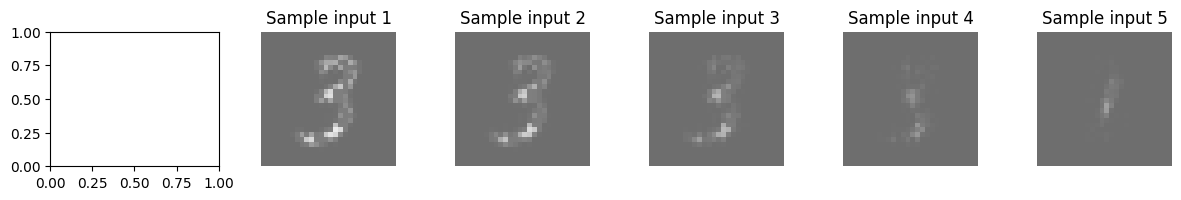

In [4]:
from utils.sampling import geodesic_interpolation_z
from utils.visualize import visualize_samples_only
samples = geodesic_interpolation_z(model, z1, z2, num_steps=5)
visualize_samples_only(samples)

In [12]:
# TODO here: Sample along Euclidean straight line vs. geodesic in latent space
# Show on the plot how this looks, where the samples come from, and how the samples look in observation space.

### Two points from the different classes (number 0 and 1)
Here, we are expecting a farther distance than the previous one. This hypothesis stems from the intuition that the features of a zero and a 1 are quite different and therefore the two should find themselves farther apart on the data manifold.

Geodesic length: 7.662184238433838
Euclidean length: 8.95729923248291


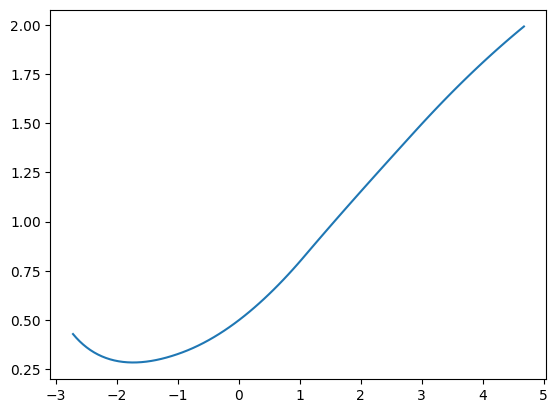

In [13]:
z1 = vals[0][0]
z2 = vals[1][0]
curve = find_geodesic(model, z1, z2)
curve.plot()
geodesic_distance = curve.euclidean_length().item()
euclidean_distance = torch.norm(z1 - z2, p=1)
print(f"Geodesic length: {geodesic_distance}")
print(f"Euclidean length: {euclidean_distance}")

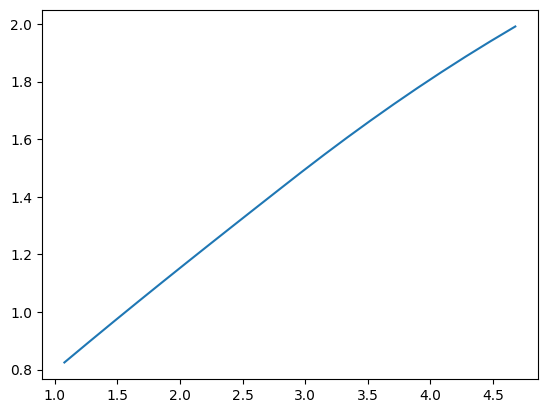

In [ ]:
import matplotlib.pyplot as plt
from utils.geodesic import points_on_geodesic

points, t = points_on_geodesic(curve, 20, 0, 0.5)

ax= None
plot_in = ax or plt
if ax is not None:
    t = t.detach().numpy()
    points = points.detach().numpy()

figs = []
for b in range(points.shape[0]):
    fig = plot_in.plot(points[b, :, 0], points[b, :, 1])
    figs.append(fig)



[<Figure size 640x480 with 1 Axes>]

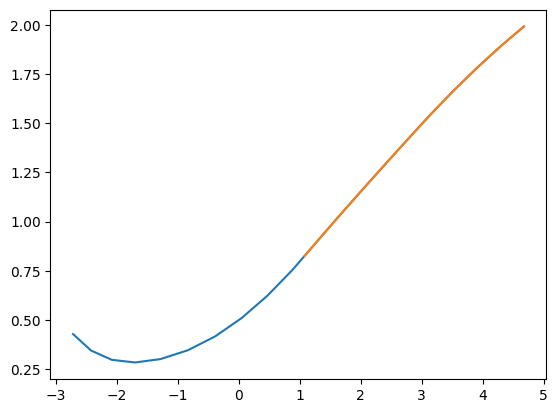

In [15]:
whole_curve, t= points_on_geodesic(curve, 20, 0, 1)
half_curve, t2 = points_on_geodesic(curve, 20, 0, 0.5)
plot_overlapped(whole_curve, half_curve, plot_in=plt, t=t)

In [16]:
points, t2 = points_on_geodesic(curve, 20, 0, 0.1)

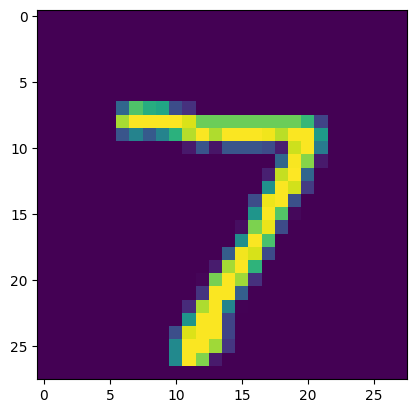

In [17]:
plt.imshow(x_test.reshape((28, 28, 1)))

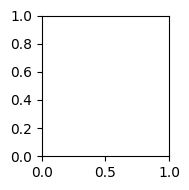

In [ ]:
from utils.sampling import geodesic_sampling
from utils.visualize import visualize_samples

samples = geodesic_sampling(model, vals, x_test, 1, torch.device("cpu"), num_samples=10)
visualize_samples(x_test, samples)

In [5]:
import torch
from models.cnn import CustomCNN

# Retrieving pred model
cnn = CustomCNN(1, 10)
cnn.load_state_dict(torch.load("pretrained_models/CNN.pth"))

<All keys matched successfully>

In [6]:
from utils.visualize import visualize_img_pred
# Retrieving one correct prediction and one misprediction
correct = None
incorrect = None
for img, label in test_loader:
    pred = cnn.predict(img)
    if pred == label and correct is None:
        correct = (img, pred)
    elif pred != label and incorrect is None:
        incorrect = (img, pred)
    
    if correct is not None and incorrect is not None:
        break

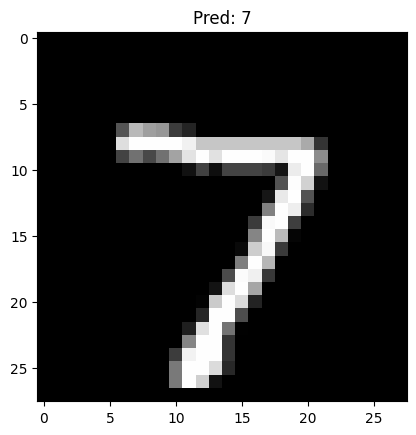

In [7]:
visualize_img_pred(correct[0], correct[1])

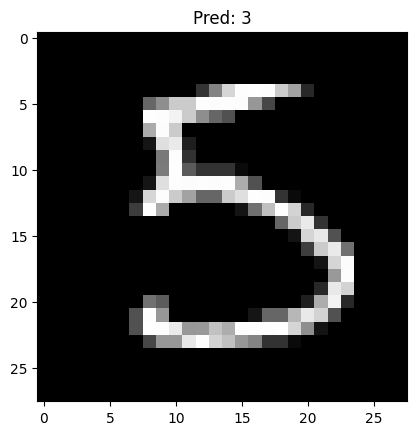

In [8]:
visualize_img_pred(incorrect[0], incorrect[1])

Curve 0 has geodesic length: 1.9616105556488037
Curve 1 has geodesic length: 1.825873851776123
Curve 2 has geodesic length: 1.5724058151245117
Curve 3 has geodesic length: 2.1358280181884766
Curve 4 has geodesic length: 2.6399941444396973
torch.Size([1, 1, 28, 28])


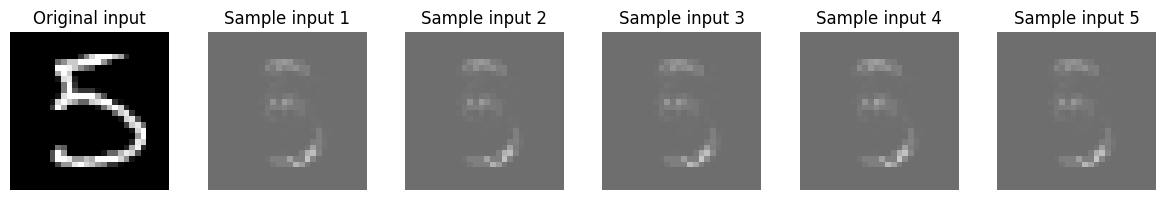

In [9]:
from utils.sampling import geodesic_sampling
from utils.visualize import visualize_samples

samples = geodesic_sampling(model, vals, incorrect[0], incorrect[1], torch.device("cpu"), num_samples=5)
visualize_samples(incorrect[0], samples)

In [ ]:
# TODO here: Sample along Euclidean straight line vs. geodesic in latent space
# Show on the plot how this looks, where the samples come from, and how the samples look in observation space.

In [ ]:
# TODO:
# 1. Visualize 2 geodesics (interclass for example the one shown above and intra class, like two mnist 5s).
# 2. Create an association table with distances between every trainingset point (both euclidean in latent and geodesic).
# 2. a. Compare the differences in distances (are there any trends such as on average further distances for a certain class or for a certain metric?)
# 3. Create method to sample along geodesic and show.
# - For this, I need to look at the CubicSpline code.

Show interesting geodesic experiments here

One that is particularly interesting is the difference between the finding the geodesic of the smooth manifold from the determnistic decoder vs. noisy from probabilistic decoder. Here, I can use the same encoder but take variance into accoutn for the probabilistic one.

The probabilistic one is more faitful to the true data manifold's geometry because unobserved data is given a higher distance value. In other words, the Jacobian is higher when the variance changes from small to large, indicating a transition to a more uncertain region of the manifold. As such, curves will be stretched in these regions and geodesics are less likely to be formed.


Thoughts:

How can I get this jacobian of the variance for the VAE? Does the variance come from decomposing the initial embedding the latent space as a mean value and a variance value conditioned on the input? 

Ok, it seems that instead of viewing the decoding as a deterministic function, it needs to be seen as the probability of an output in observation space conditioned on a latent representation. Outputs from the decoder are no longer point estimates but rather probability distributions.